Philippe Joly 2024-07-10

# Football Field Line Detection

This is an attempt at detecting and segmenting Hashmark lines on a football field. The methods used here are inspired by [Will Riedel, Devin Guillory, Tim Mwangi](https://stacks.stanford.edu/file/druid:yt916dh6570/Guillory_Mwangi_Riedel_Player_Identification_and_Tracking.pdf).

## Loading Images

In [162]:
import cv2
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd

In [163]:
test_imgs = [
    "./test_images/field.jpeg",
    "./test_images/1.jpg",
    "./test_images/2.jpg",
    "./test_images/field2.jpg",
    "./test_images/test_img.png",
    "./test_images/test_img2.png"
]

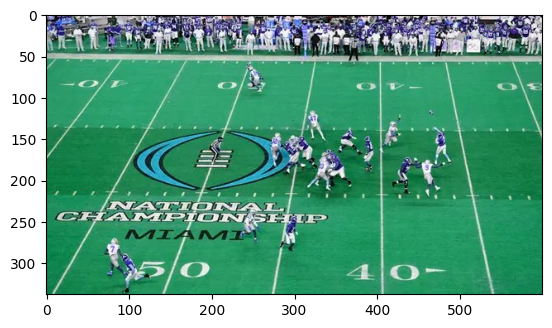

In [164]:
img_og = cv2.imread(test_imgs[4])
plt.imshow(img_og)

# Preprocessing

In [165]:
hsv = cv2.cvtColor(img_og, cv2.COLOR_BGR2HSV)
_, binary = cv2.threshold(hsv, 175, 255, cv2.THRESH_BINARY)

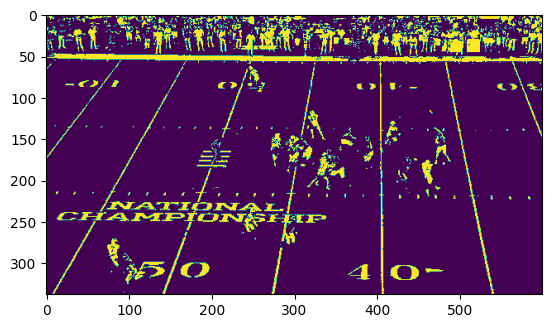

In [166]:
# HSV 
## hue 0->179
## saturation 0->255
## value 0->255

lower_white = np.array([0,0,180])
upper_white = np.array([180, 100, 255])

hsv = cv2.cvtColor(img_og, cv2.COLOR_BGR2HSV)
binary = cv2.inRange(hsv, lower_white, upper_white)
plt.imshow(binary)

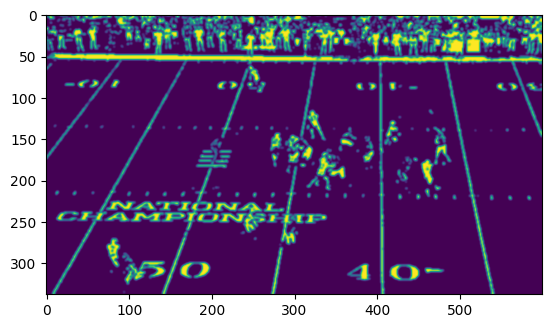

In [167]:
binary_blurred = cv2.GaussianBlur(binary, (5, 5), 0)
plt.imshow(binary_blurred)

## Line Detection

In [168]:
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

filtered_contours = []
for contour in contours:
    area = cv2.contourArea(contour)
    if area < 0 or area > 5:
        continue

    rect = cv2.minAreaRect(contour)
    (x, y), (w, h), angle = rect

    filtered_contours.append(contour)

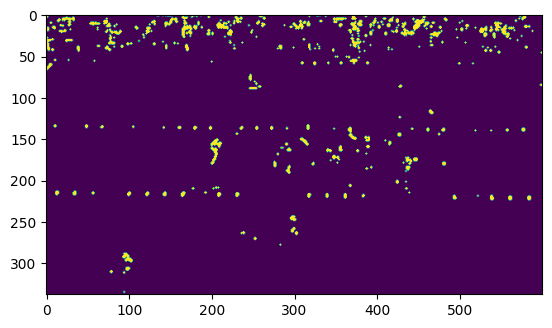

In [169]:
mask = np.zeros_like(binary)
cv2.drawContours(mask, filtered_contours, -1, (255), 2)
plt.imshow(mask)

In [170]:
# Hough Lines
## params
rho = 1  # Distance resolution in pixels
theta = np.pi / 180  # Angle resolution in radians
threshold = 250  # Accumulator threshold
minLineLength = 200  # Minimum length of a line
maxLineGap = 50  # Maximum allowed gap between points on the same line

lines = cv2.HoughLinesP(mask, rho=rho, theta=theta, threshold=threshold, minLineLength=minLineLength, maxLineGap=maxLineGap)

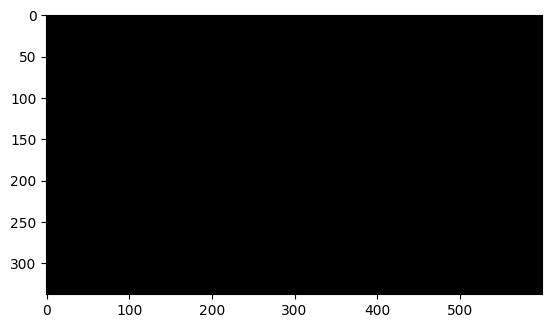

In [171]:
lines_draw = np.zeros_like(img_og)

if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(lines_draw, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.imshow(lines_draw)

## Merge Lines

In [172]:
def get_dis(p1, p2):
    return np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

def get_basis(p1, p2):
    return p2-p1

def get_angles(p1, p2):
    basis = get_basis(p1,p2)

    angle1 = np.rad2deg(np.atan2(basis[1], basis[0]))
    angle2 = angle1 + 180

    if angle1 < 0:
        angle1 = 360 + angle1

    return [angle1, angle2]

def project(basis, v):
    return (np.dot(v, basis)/np.dot(v, v) * v).astype(np.int64)

In [173]:
line_list = []
for id, line in enumerate(lines):
    p1 = np.array(line[0][:2])
    p2 = np.array(line[0][2:])
    line_list.append({'id': id+1, 'p1': p1, 'p2': p2, 'len': get_dis(p1, p2), 'basis': get_basis(p1, p2), 'angles': get_angles(p1, p2), 'merged': False, 'merges': 0})
line_list.sort(key=lambda x: x['len'])

TypeError: 'NoneType' object is not iterable

In [ ]:
def show_lines(lines, img, back=False):
    lines_draw = img.copy() if back else np.zeros_like(img)
    if lines is not None:
        for line in lines:
            cv2.line(lines_draw, (line['p1'][0], line['p1'][1]), (line['p2'][0], line['p2'][1]), (255, 0, 0), 5)

    plt.imshow(lines_draw)

In [ ]:
def get_closest_pt(basis_line, p_l2):
    a, b = basis_line['p1'],basis_line['p2']
    u = b-a
    v = p_l2-a

    t = np.dot(u,v)/np.dot(u,u)
    
    if t <= 0:
        return a
    elif t >= 1:
        return b
    
    return (a+t*(b-a)).astype(np.int64)
 
def dis_to_line(basis_line, p_l2):
    p_l1 = get_closest_pt(basis_line, p_l2)
    return get_dis(p_l1, p_l2)

def merge_lines(basis_line, merged_line):
    a, b = basis_line['p1'],basis_line['p2']
    u = b-a
    v1 = merged_line['p1']-a
    v2 = merged_line['p2']-a

    t1 = np.dot(u,v1)/np.dot(u,u)
    t2 = np.dot(u,v2)/np.dot(u,u)

    c1 = (a+t1*(b-a)).astype(np.int64)
    c2 = (a+t2*(b-a)).astype(np.int64)

    if t1 <= 0:
        basis_line['p1'] = c1
    elif t1 >= 1:
        basis_line['p2'] = c1

    if t2 <= 0 and t2 <= t1:
        basis_line['p1'] = c2
    elif t2 >= 1 and t2 >= t1:
        basis_line['p2'] = c2

    merged_line['merged'] = basis_line['id']
    basis_line['merges'] += 1  

    ### ***handle out of bounds projections*** 
    

In [ ]:
def should_merge(basis_line, merged_line, angle_treshold, dis_treshold):
    # the edges of merged_line suffice to find closest distance between the 2 lines as they are supposidely parallel and the merged_line is always shorter than the basis_line (sorted)
   
    delta_angle = min(
        abs(basis_line['angles'][0] - merged_line['angles'][0]),
        abs(basis_line['angles'][1] - merged_line['angles'][0]),
        abs(basis_line['angles'][0] - merged_line['angles'][1]),
        abs(basis_line['angles'][0] - merged_line['angles'][0])
    )

    if delta_angle < angle_treshold:
        dis_p1 = dis_to_line(basis_line, merged_line['p1'])
        dis_p2 = dis_to_line(basis_line, merged_line['p2'])

        if dis_p1 < dis_treshold or dis_p2 < dis_treshold:
            return True    
    return False    

In [ ]:
# main merging loop
list_length = len(line_list)
for i in range(list_length-1):
    for j in range(list_length-1, i, -1):
        if should_merge(line_list[j], line_list[i], 5, 50):
            merge_lines(line_list[j], line_list[i])
            break
merged_lines = [l for l in line_list if not l['merged']]

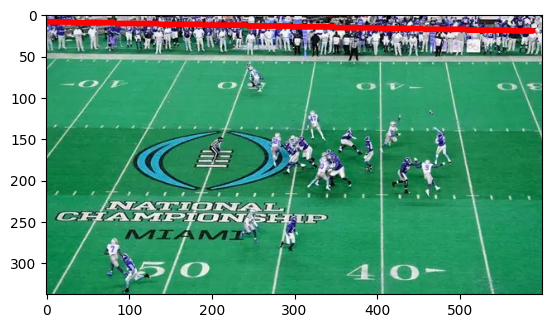

In [ ]:
show_lines(merged_lines, img_og, back=True)